In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Convolutional Neural Networks

## The Magic of Convolutions

In [5]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
#hide
Path.BASE_PATH = path

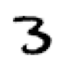

In [8]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [10]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [11]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [12]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [13]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [14]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [15]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [16]:
apply_kernel(5,7,top_edge)

tensor(762.)

### Mapping a Convolution Kernel

In [21]:
[[(i,j) for j in range(1,5)] for i in range(1,6)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)],
 [(5, 1), (5, 2), (5, 3), (5, 4)]]

In [25]:
# detect diffs from top edge borders with filter/kenel
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

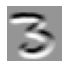

In [26]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] 
                    for i in rng])

show_image(top_edge3);

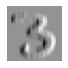

In [27]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

### Convolutions in PyTorch

In [28]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [29]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [30]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [33]:
# add a dim for channel (gscale in mnist
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [34]:
edge_kernels = edge_kernels.unsqueeze(1)

In [40]:
# apply 
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

In [51]:
F.conv2d??

Docstring:
conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor

Applies a 2D convolution over an input image composed of several input
planes.

This operator supports :ref:`TensorFloat32<tf32_on_ampere>`.

See :class:`~torch.nn.Conv2d` for details and output shape.

Note:
    In some circumstances when given tensors on a CUDA device and using CuDNN, this operator may select a nondeterministic algorithm to increase performance. If this is undesirable, you can try to make the operation deterministic (potentially at a performance cost) by setting ``torch.backends.cudnn.deterministic = True``. See :doc:`/notes/randomness` for more information.

Note:
    This operator supports complex data types i.e. ``complex32, complex64, complex128``.


Args:
    input: input tensor of shape :math:`(\text{minibatch} , \text{in\_channels} , iH , iW)`
    weight: filters of shape :math:`(\text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW)`
    bias

In [41]:
# image is reducing in size
xb.shape

torch.Size([64, 1, 28, 28])

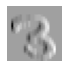

In [42]:
show_image(batch_features[0,0]);

### Strides and Padding

### Understanding the Convolution Equations

## Our First Convolutional Neural Network

### Creating the CNN

In [45]:
# prevous chapter example
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [46]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [48]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1), # 3x3 kernel, padding as not to loose size 
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

In [49]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [55]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [61]:
test = conv(1,4)(xb)

In [86]:
test.shape # 1 channel in (grey scale) , 4 out, img reduction in half

torch.Size([64, 4, 14, 14])

<AxesSubplot:>

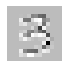

In [87]:
show_image(test[7][3])

In [89]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [90]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [91]:
learn = Learner(dls, simple_cnn, 
                loss_func=F.cross_entropy, metrics=accuracy)

In [92]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [93]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.063480,0.041998,0.985280,00:06
1,0.020496,0.026880,0.990186,00:07


### Understanding Convolution Arithmetic

**COPY from BOOK**
We can now use this information to clarify our statement in the previous section: "When we use a stride-2 convolution, we often increase the number of features because we're decreasing the number of activations in the activation map by a factor of 4; we don't want to decrease the capacity of a layer by too much at a time."

There is one bias for each channel. (Sometimes channels are called *features* or *filters* when they are not input channels.) The output shape is `64x4x14x14`, and this will therefore become the input shape to the next layer. The next layer, according to `summary`, has 296 parameters. Let's ignore the batch axis to keep things simple. So for each of `14*14=196` locations we are multiplying `296-8=288` weights (ignoring the bias for simplicity), so that's `196*288=56_448` multiplications at this layer. The next layer will have `7*7*(1168-16)=56_448` multiplications.

What happened here is that our stride-2 convolution halved the *grid size* from `14x14` to `7x7`, and we doubled the *number of filters* from 8 to 16, resulting in no overall change in the amount of computation. If we left the number of channels the same in each stride-2 layer, the amount of computation being done in the net would get less and less as it gets deeper. But we know that the deeper layers have to compute semantically rich features (such as eyes or fur), so we wouldn't expect that doing *less* computation would make sense.

In [97]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [104]:
# weights of layer 1
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [107]:
4*3*3 + 4 # 40 params

40

In [108]:
m[0].bias.shape

torch.Size([4])

### Receptive Fields

### A Note About Twitter

## Color Images

In [110]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

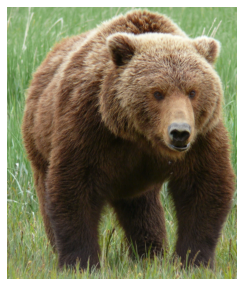

In [111]:
show_image(im);

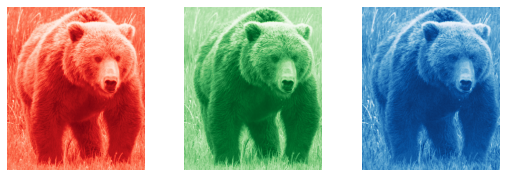

In [112]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

## Improving Training Stability

In [113]:
# using whole mnist to recongise all 10 digits
path = untar_data(URLs.MNIST)

In [114]:
#hide
Path.BASE_PATH = path

In [115]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [116]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

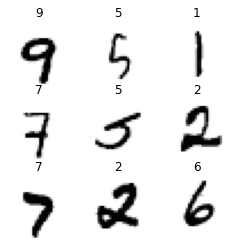

In [117]:
dls.show_batch(max_n=9, figsize=(4,4))

### A Simple Baseline

In [119]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [120]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [121]:
from fastai.callback.hook import *

In [122]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [123]:
learn = fit()

/root/.local/lib/python3.9/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305385,2.309260,0.102800,01:53


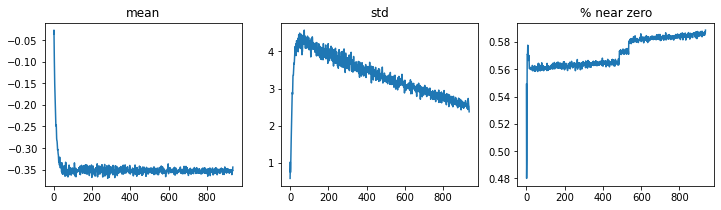

In [124]:
learn.activation_stats.plot_layer_stats(0)

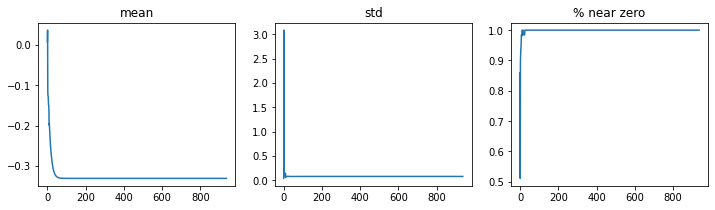

In [125]:
learn.activation_stats.plot_layer_stats(-2)

As expected, the problems get worse towards the end of the network, as the instability and zero activations compound over layers. Let's look at what we can do to make training more stable.

### Increase Batch Size

In [126]:
dls = get_dls(512)

In [127]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.396922,0.305124,0.905500,02:16


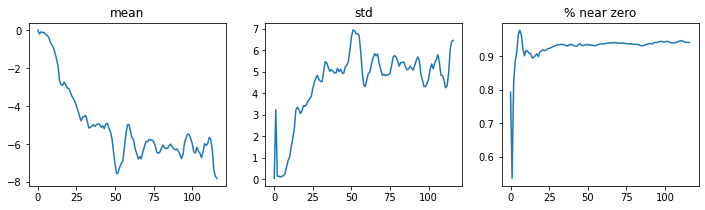

In [129]:
learn.activation_stats.plot_layer_stats(-2)
# still close to zero 

### 1cycle Training

In [130]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [131]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.200781,0.069967,0.977200,02:45


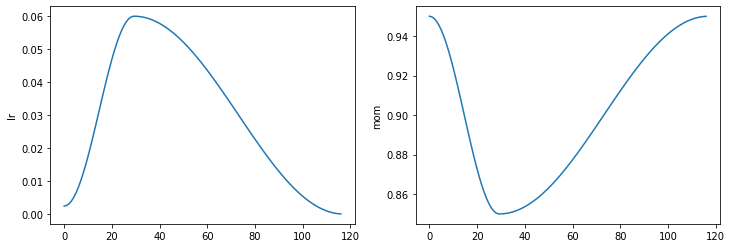

In [132]:
learn.recorder.plot_sched()

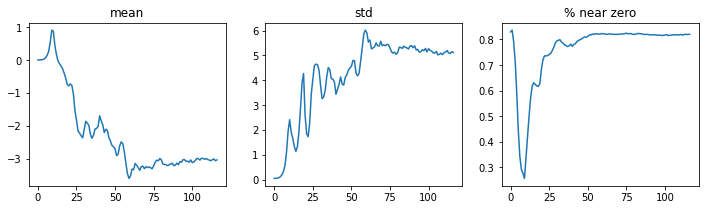

In [133]:
learn.activation_stats.plot_layer_stats(-2)

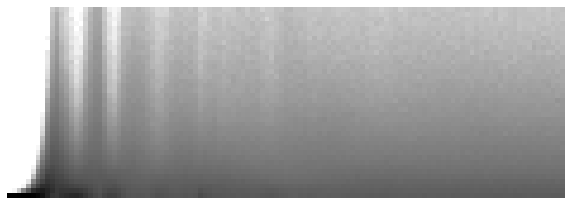

In [134]:
learn.activation_stats.color_dim(-2)

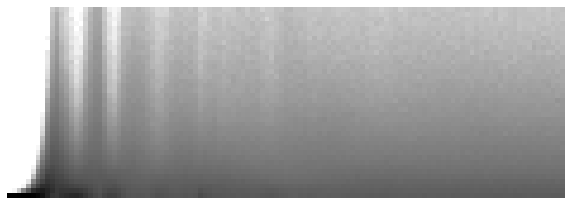

In [135]:
learn.activation_stats.color_dim(-2)

### Batch Normalization

In [136]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [ ]:
learn = fit()

In [ ]:
learn.activation_stats.color_dim(-4)

In [ ]:
learn = fit(5, lr=0.1)

## Conclusions

## Questionnaire

1. What is a "feature"?
1. Write out the convolutional kernel matrix for a top edge detector.
1. Write out the mathematical operation applied by a 3×3 kernel to a single pixel in an image.
1. What is the value of a convolutional kernel apply to a 3×3 matrix of zeros?
1. What is "padding"?
1. What is "stride"?
1. Create a nested list comprehension to complete any task that you choose.
1. What are the shapes of the `input` and `weight` parameters to PyTorch's 2D convolution?
1. What is a "channel"?
1. What is the relationship between a convolution and a matrix multiplication?
1. What is a "convolutional neural network"?
1. What is the benefit of refactoring parts of your neural network definition?
1. What is `Flatten`? Where does it need to be included in the MNIST CNN? Why?
1. What does "NCHW" mean?
1. Why does the third layer of the MNIST CNN have `7*7*(1168-16)` multiplications?
1. What is a "receptive field"?
1. What is the size of the receptive field of an activation after two stride 2 convolutions? Why?
1. Run *conv-example.xlsx* yourself and experiment with *trace precedents*.
1. Have a look at Jeremy or Sylvain's list of recent Twitter "like"s, and see if you find any interesting resources or ideas there.
1. How is a color image represented as a tensor?
1. How does a convolution work with a color input?
1. What method can we use to see that data in `DataLoaders`?
1. Why do we double the number of filters after each stride-2 conv?
1. Why do we use a larger kernel in the first conv with MNIST (with `simple_cnn`)?
1. What information does `ActivationStats` save for each layer?
1. How can we access a learner's callback after training?
1. What are the three statistics plotted by `plot_layer_stats`? What does the x-axis represent?
1. Why are activations near zero problematic?
1. What are the upsides and downsides of training with a larger batch size?
1. Why should we avoid using a high learning rate at the start of training?
1. What is 1cycle training?
1. What are the benefits of training with a high learning rate?
1. Why do we want to use a low learning rate at the end of training?
1. What is "cyclical momentum"?
1. What callback tracks hyperparameter values during training (along with other information)?
1. What does one column of pixels in the `color_dim` plot represent?
1. What does "bad training" look like in `color_dim`? Why?
1. What trainable parameters does a batch normalization layer contain?
1. What statistics are used to normalize in batch normalization during training? How about during validation?
1. Why do models with batch normalization layers generalize better?

### Further Research

1. What features other than edge detectors have been used in computer vision (especially before deep learning became popular)?
1. There are other normalization layers available in PyTorch. Try them out and see what works best. Learn about why other normalization layers have been developed, and how they differ from batch normalization.
1. Try moving the activation function after the batch normalization layer in `conv`. Does it make a difference? See what you can find out about what order is recommended, and why.